In [4]:
import tensorflow as tf
from tensorflow.keras.models import load_model



In [5]:
# Specify the path to your .h5 model file
model_path = '../webapp/unet_model_full.h5'

# Load the model
model = load_model(model_path)

# Print the model summary to verify
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 100, 625,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 100, 625,  │        320 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 100, 625,  │      9,248 │ conv2d[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 50, 312,   │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 50, 312,   │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 50, 312,   │     36,928 │ conv2d_2[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 100, 624,  │      8,224 │ conv2d_3[0][0]    │
│ (Conv2DTranspose)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cropping2d          │ (None, 100, 624,  │          0 │ conv2d_1[0][0]    │
│ (Cropping2D)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 100, 624,  │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 64)               │            │ cropping2d[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 100, 624,  │     18,464 │ concatenate[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 100, 624,  │      9,248 │ conv2d_4[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 100, 624,  │         33 │ conv2d_5[0][0]    │
│                     │ 1)                │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 100,963 (394.39 KB)

 Trainable params: 100,961 (394.38 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [6]:
from PIL import Image
import numpy as np

def convert_to_grayscale_and_resize(image_path, new_size=(625, 100)):
    with Image.open(image_path) as img:
        
        # Convert the image to grayscale
        img_gray = img.convert("L")
        img_resized = img_gray.resize(new_size, Image.Resampling.LANCZOS)
        image_array = np.array(img_resized)
        
        return image_array

In [7]:
import cv2
import numpy as np
from scipy.ndimage import zoom

def resize_array(array, new_size):
    original_size = array.shape
    scale = [n / o for n, o in zip(new_size, original_size)]
    
    resized_array = zoom(array, zoom=scale, order=1)  

    return resized_array

def mask_generator(tags, image_path):
    en_pix = tags.split()
    rle = list(map(int, en_pix))
    pixel = [rle[i] for i in range(0, len(rle), 2)]
    pixel_count = [rle[i] for i in range(1, len(rle), 2)]
    
    # Generate RLE pixels
    rle_pixels = [list(range(pixel[i], pixel[i] + pixel_count[i])) for i in range(len(pixel))]
    rle_mask_pixels = sum(rle_pixels, [])
    
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Image not found at {image_path}")
    
    # Get image dimensions
    l, b, _ = img.shape
    max_index = l * b - 1
    rle_mask_pixels = [min(pixel, max_index) for pixel in rle_mask_pixels] 
    mask_img = np.zeros((l * b,), dtype=np.uint8)
    
    # Set pixels of interest to 1 (instead of 100)
    mask_img[rle_mask_pixels] = 1
    
    mask = mask_img.reshape((b, l)).T
    
    new_size = (625, 100)
    resized_array = cv2.resize(mask, new_size)
    
    return resized_array

In [9]:
import pandas as pd
CSV_PATH = "../Datasets/Severstal steel defect detection/train.csv"
data = pd.read_csv(CSV_PATH, header=None)
image_path = data[0]
image_enpix = [f"../Datasets/Severstal steel defect detection/train_images/{image_name}" for image_name in data[0]]
train_x = np.array(image_enpix)
train_y= np.array(data[2])
image_dataset = np.delete(train_x, 0)
damage_dataset = np.delete(train_y, 0)
train_y = [mask_generator(damage, image) for damage, image in zip(damage_dataset, image_dataset)]
train_x = [convert_to_grayscale_and_resize(image_path, new_size=(625, 100)) for image_path in image_dataset]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


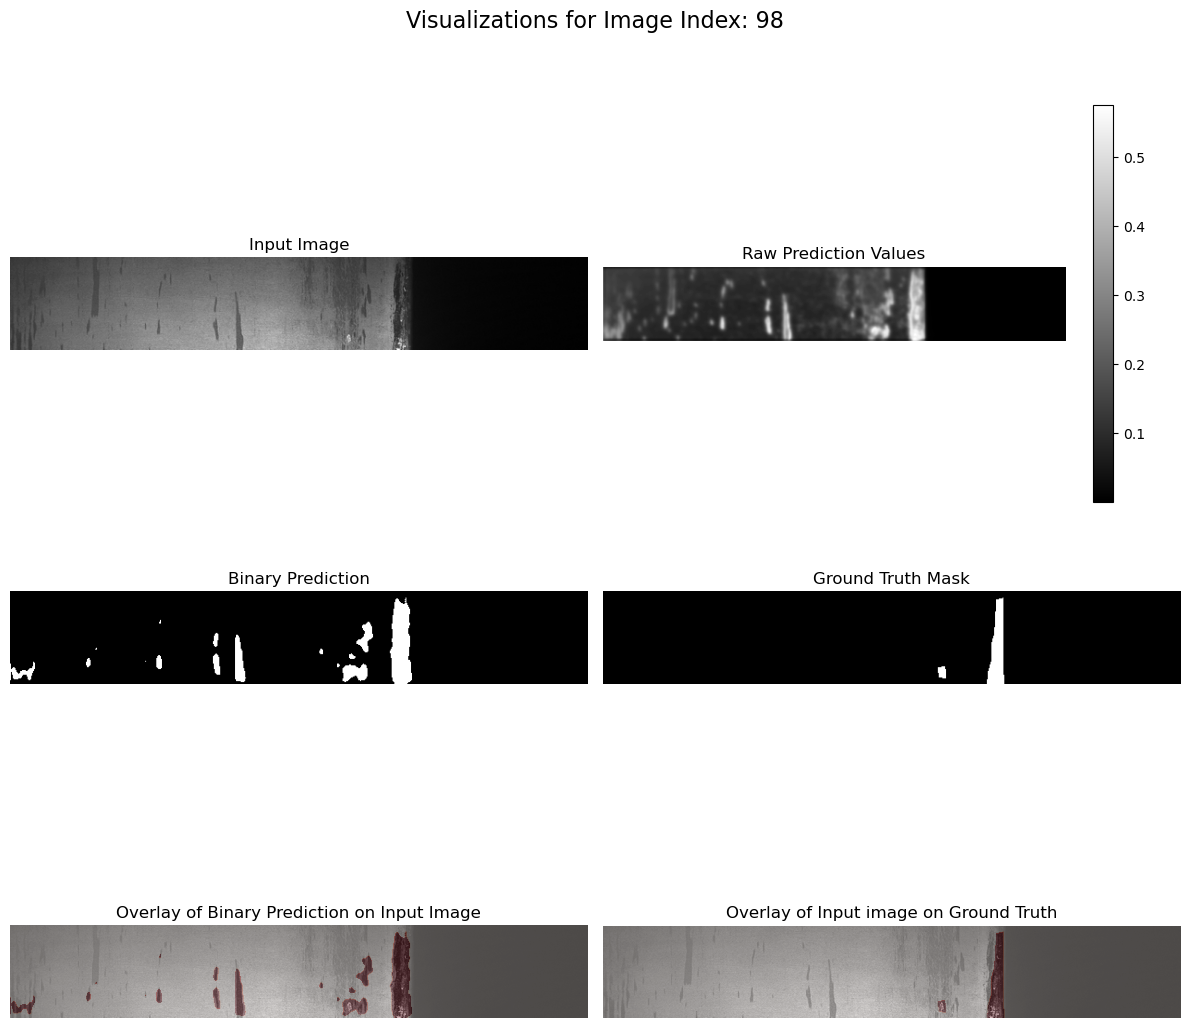

In [10]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_predictions(model, train_x, train_y, index):
    # Prepare the sample input
    sample_input = np.expand_dims(train_x[index], axis=0)/255
    
    # Get the prediction
    prediction = model.predict(sample_input)
    
    # Apply a threshold to create binary prediction
    threshold = 0.3
    binary_prediction = (prediction > threshold).astype(int)
    
    # Set up the figure and axes
    fig, axs = plt.subplots(3, 2, figsize=(12, 12))
    fig.suptitle(f"Visualizations for Image Index: {index}", fontsize=16)

    # Input Image
    axs[0, 0].imshow(sample_input.reshape(100, 625), cmap="gray")
    axs[0, 0].set_title("Input Image")
    axs[0, 0].axis('off')

    # Raw Prediction
    raw_pred_img = axs[0, 1].imshow(np.squeeze(prediction), cmap="gray")
    axs[0, 1].set_title("Raw Prediction Values")
    fig.colorbar(raw_pred_img, ax=axs[0, 1])
    axs[0, 1].axis('off')

    # Binary Prediction
    axs[1, 0].imshow(np.squeeze(binary_prediction), cmap="gray")
    axs[1, 0].set_title("Binary Prediction")
    axs[1, 0].axis('off')

  # Ground Truth
    ground_truth = np.squeeze(train_y[index])  # Squeeze to remove the last dimension
    axs[1, 1].imshow(ground_truth, cmap="gray")
    axs[1, 1].set_title("Ground Truth Mask")
    axs[1, 1].axis('off')

    # Overlay Prediction on Input Image
    axs[2, 0].imshow(sample_input.reshape(100, 625), cmap="gray", interpolation='none')
    axs[2, 0].imshow(np.squeeze(binary_prediction), cmap="Reds", alpha=0.3)
    axs[2, 0].set_title("Overlay of Binary Prediction on Input Image")
    axs[2, 0].axis('off')

    # Input image on Ground Truth
    axs[2, 1].imshow(sample_input.reshape(100, 625), cmap="gray", interpolation='none')
    axs[2, 1].imshow(ground_truth, cmap="Reds", alpha=0.3)
    axs[2, 1].set_title("Overlay of Input image on Ground Truth")
    axs[2, 1].axis('off')

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

# Example usage
index_to_visualize = 98 # Change this to any index you want to visualize
visualize_predictions(model, train_x, train_y, index_to_visualize)

Average IoU: 0.2568
Average Dice Coefficient: 0.3786
Average Pixel-wise Accuracy: 0.9201


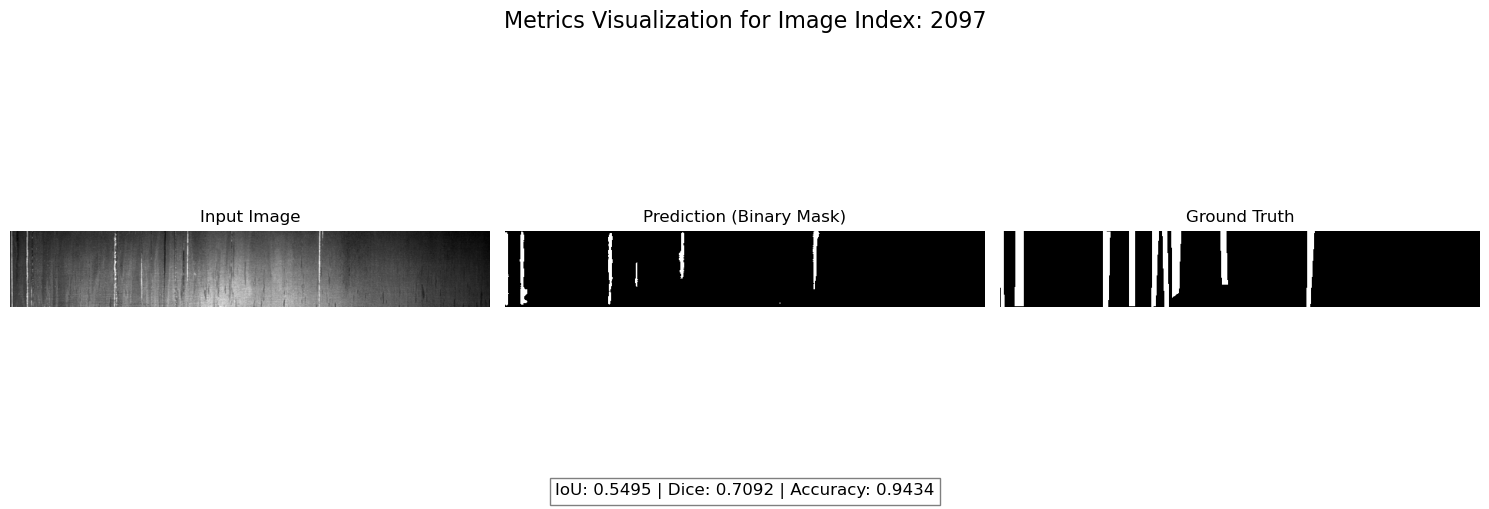

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

def calculate_metrics(y_true, y_pred, threshold=0.3):
    # Ensure y_true and y_pred have the same shape
    if y_true.shape != y_pred.shape:
        print(f"Warning: Shape mismatch. y_true: {y_true.shape}, y_pred: {y_pred.shape}")
        # Resize y_pred to match y_true
        y_pred = cv2.resize(y_pred, (y_true.shape[1], y_true.shape[0]))
    
    # Convert prediction to binary mask
    y_pred_binary = (y_pred > threshold).astype(np.float32)
    
    y_true_f = y_true.flatten()
    y_pred_f = y_pred_binary.flatten()
    
    intersection = np.sum(y_true_f * y_pred_f)
    union = np.sum(y_true_f) + np.sum(y_pred_f) - intersection
    
    iou = intersection / (union + 1e-7)
    dice = (2 * intersection) / (np.sum(y_true_f) + np.sum(y_pred_f) + 1e-7)
    accuracy = np.mean(y_true_f == y_pred_f)
    
    return iou, dice, accuracy

def evaluate_model(model, train_x, train_y, num_samples=500):
    indices = np.random.choice(len(train_x), num_samples, replace=False)
    iou_list, dice_list, accuracy_list = [], [], []
    
    for idx in indices:
        x = train_x[idx]
        y = train_y[idx]
        x_input = np.expand_dims(x, axis=0) / 255
        prediction = model.predict(x_input, verbose=0)
        iou, dice, accuracy = calculate_metrics(y, np.squeeze(prediction))
        iou_list.append(iou)
        dice_list.append(dice)
        accuracy_list.append(accuracy)
    
    return {
        'IoU': np.mean(iou_list),
        'Dice': np.mean(dice_list),
        'Accuracy': np.mean(accuracy_list)
    }

# Evaluate the model on a subset of the dataset
num_samples = 500  # You can adjust this number
metrics = evaluate_model(model, train_x, train_y, num_samples)
print(f"Average IoU: {metrics['IoU']:.4f}")
print(f"Average Dice Coefficient: {metrics['Dice']:.4f}")
print(f"Average Pixel-wise Accuracy: {metrics['Accuracy']:.4f}")

# Visualize metrics for a specific image
index_to_visualize = np.random.choice(len(train_x))  # Randomly choose an index

sample_input = np.expand_dims(train_x[index_to_visualize], axis=0)/255
prediction = model.predict(sample_input, verbose=0)
iou, dice, accuracy = calculate_metrics(train_y[index_to_visualize], np.squeeze(prediction))

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle(f"Metrics Visualization for Image Index: {index_to_visualize}", fontsize=16)

axs[0].imshow(sample_input.reshape(100, 625), cmap="gray")
axs[0].set_title("Input Image")
axs[0].axis('off')

axs[1].imshow(np.squeeze(prediction > 0.5), cmap="gray")
axs[1].set_title("Prediction (Binary Mask)")
axs[1].axis('off')

axs[2].imshow(train_y[index_to_visualize], cmap="gray")
axs[2].set_title("Ground Truth")
axs[2].axis('off')

plt.figtext(0.5, 0.01, f'IoU: {iou:.4f} | Dice: {dice:.4f} | Accuracy: {accuracy:.4f}', 
            ha='center', fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

plt.tight_layout()
plt.show()